A simple pipeline for testing the classification. 

- Step 1: Load data
- Step 2: Load CLIP
    - Extract text features
    - Extract image features
- Step 3: Merge features
- Step 4: Train the classifier

In [1]:
import torch  # PyTorch for deep learning
import pandas as pd  # Pandas for handling tabular data
import re
from transformers import CLIPTokenizer, CLIPProcessor, CLIPModel
from PIL import Image  # Pillow for image processing
from sklearn.model_selection import train_test_split  # Splitting data into training/testing sets
from sklearn.preprocessing import StandardScaler  # Feature scaling
from sklearn.ensemble import RandomForestClassifier  # A simple machine learning classifier
from sklearn.metrics import classification_report  # Evaluation metrics for classification
import numpy as np  # NumPy for numerical operations

c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import easyocr

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.__version__

'2.5.1'

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available, otherwise fallback to CPU
print(device)

cuda


In [7]:
df = pd.read_excel("D:/sample_images_full.xlsx")

In [101]:
# Load model and tokenizer
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").eval()
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
reader = easyocr.Reader(["no", "en"])  # Norwegian and English 

# Function to extract text from images:
def extract_text_easyocr(image_path):
    """Extracts text from an image using EasyOCR."""
    try:
        results = reader.readtext(image_path, detail=0)  # Extract text without coordinates
        return " ".join(results)  # Join extracted words into a single string
    except Exception as e:
        print(f"OCR failed for {image_path}: {e}")
        return ""

c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\easyocr\detection.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load

In [85]:
def get_text_features(text):
    max_tokens = 77
    tokens = clip_processor.tokenizer(text, return_tensors="pt", padding=False, truncation=False).input_ids[0]
    token_chunks = [tokens[i:i + max_tokens] for i in range(0, len(tokens), max_tokens)]

    text_chunks = [clip_processor.tokenizer.decode(chunk, skip_special_tokens=True) for chunk in token_chunks]

    chunk_features = []
    for chunk in text_chunks:
        inputs = clip_processor(text=chunk, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            features = clip_model.get_text_features(**inputs).squeeze().cpu().numpy()
        chunk_features.append(features)

    final_text_features = np.mean(chunk_features, axis=0) if chunk_features else np.zeros((512,))
    return final_text_features

In [13]:
# Function to extract image features
def get_image_features(image_path):
    """Extracts image embeddings from CLIP."""
    image = Image.open(image_path).convert("RGB")
    inputs = clip_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)
    return image_features.cpu().numpy()

In [14]:
df["image_path_image_filename_image_1"] = df["image_path_image_filename_image_1"].str.replace(r"^D:/", "E:/", regex=True)

In [17]:
import PIL
PIL.Image.ANTIALIAS = PIL.Image.LANCZOS

# Extract text from images
df["image_text"] = df["image_path_image_filename_image_1"].apply(extract_text_easyocr)

c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


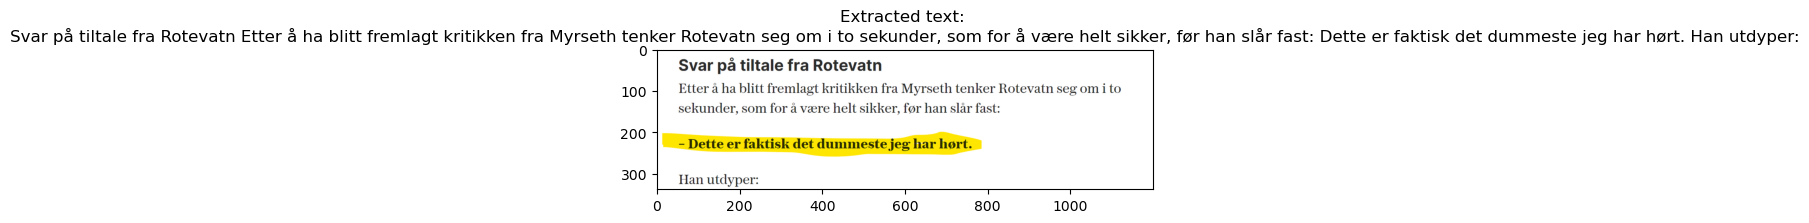

In [52]:
import cv2
import matplotlib.pyplot as plt

sampled_df = df.sample(5, random_state=2)

for idx, row in sampled_df.iterrows():
    image_path = row["image_path_image_filename_image_1"]
    extracted_text = row["image_text"] 

    image = cv2.imread(image_path)
    if image is None:
        print(f"No image")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(image)
plt.title(f"Extracted text: \n{extracted_text}")
plt.show()

In [54]:
# Merge extracted text with tweet text
df["combined_text"] = df["tweet"] + " " + df["image_text"]

In [86]:
# Extract text and image features
df["text_features"] = df["combined_text"].apply(get_text_features)

In [36]:
df["image_features"] = df["image_path_image_filename_image_1"].apply(
    lambda x: get_image_features(x) if pd.notna(x) else None
)

c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [87]:
def combine_features(text_emb, image_emb):
    """
    Combines text and image embeddings into a single vector.

    Parameters:
        text_emb (np.array): Text embedding vector (512-dim).
        image_emb (np.array): Image embedding vector (512-dim).

    Returns:
        np.array: Concatenated feature vector (1024-dim).
    """
    # Ensure embeddings are numpy arrays
    text_emb = np.array(text_emb).flatten()
    image_emb = np.array(image_emb).flatten()

    # Handle missing image embeddings (use zero vector if missing)
    if np.all(image_emb == 0):  
        print("⚠️ Missing image embedding, using only text features.")

    # Concatenate text and image features
    return np.concatenate([text_emb, image_emb])

# Apply the function to all rows
df["combined_features"] = df.apply(lambda row: combine_features(row["text_features"], row["image_features"]), axis=1)

In [88]:
print(df.head())

                                               tweet  label  \
0  Tror neppe jeg hadde klart å caste en kar som ...      1   
1  NRK forsiden: Kvinne smittet av Coronavirus i ...      0   
2  Da er vi sikra. Vaksinen mot Corona-viruset er...      1   
3  NRK Oslo og Viken: Folkehelsa om corona-karant...      0   
4  NRK Nordland: Ingen grunn til corona-bekymring...      0   

                    id       date  \
0  1221795275876044801 2020-01-01   
1  1223269853445779456 2020-01-01   
2  1221176911516356608 2020-01-01   
3  1221796006888529922 2020-01-01   
4  1222808933665914880 2020-01-01   

              image_path_image_filename_image_1  \
0  E:/Images/Covid/images_2/EPSwU1AXsAAQ_HD.jpg   
1  E:/Images/Covid/images_2/EPntcuPU8AIglrX.jpg   
2  E:/Images/Covid/images_2/EPJ97EGWkAMG55v.jpg   
3  E:/Images/Covid/images_2/EPSw_j9UUAAGgAN.jpg   
4  E:/Images/Covid/images_2/EPhKPrqUwAEcBJ6.jpg   

  image_path_image_filename_image_2 image_path_image_filename_image_3  \
0                 

In [89]:
print(df.dtypes)

tweet                                        object
label                                         int64
id                                            int64
date                                 datetime64[ns]
image_path_image_filename_image_1            object
image_path_image_filename_image_2            object
image_path_image_filename_image_3            object
image_path_image_filename_image_4            object
image_text                                   object
combined_text                                object
text_features                                object
image_features                               object
combined_features                            object
dtype: object


In [90]:
print(df["combined_features"].apply(lambda x: np.array(x).shape).value_counts())

combined_features
(1024,)    2177
Name: count, dtype: int64


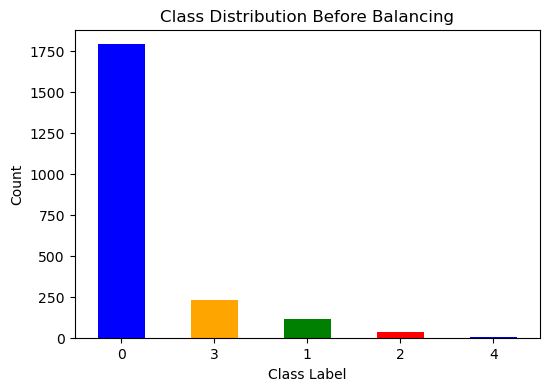

label
0    1789
3     231
1     117
2      37
4       3
Name: count, dtype: int64


In [25]:
import matplotlib.pyplot as plt

# Count occurrences of each label
class_counts = df["label"].value_counts()

# Plot class distribution
plt.figure(figsize=(6,4))
class_counts.plot(kind="bar", color=["blue", "orange", "green", "red"])
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Class Distribution Before Balancing")
plt.xticks(rotation=0)
plt.show()

print(class_counts)  # Print exact numbers

In [91]:
# Convert multi-class labels to binary: 0 = non-humor, 1 = humor
df["label"] = df["label"].apply(lambda x: 1 if x in [1, 2, 3] else 0)

# Verify new class distribution
print(df["label"].value_counts())

label
0    1792
1     385
Name: count, dtype: int64


In [92]:
# Split the dataset 
X_train, X_test, y_train, y_test = train_test_split(df["combined_features"], df["label"], test_size=0.2, random_state=42, stratify=df["label"])

# Print dataset sizes
print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")

Training set size: 1741, Test set size: 436


In [93]:
from imblearn.over_sampling import SMOTE

# Convert to NumPy arrays for SMOTE
X_train = np.array(X_train.tolist())  # Convert list of arrays to 2D NumPy array
y_train = np.array(y_train)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print new class distribution
from collections import Counter
print("Resampled class distribution:", Counter(y_train_resampled))

Resampled class distribution: Counter({1: 1433, 0: 1433})


In [94]:
# Convert original and resampled feature sets to sets of tuples for comparison
original_feature_set = set(map(tuple, np.round(df["combined_features"], decimals=6)))  # Round to avoid floating-point precision errors
resampled_feature_set = set(map(tuple, np.round(X_train_resampled, decimals=6)))

# Find the synthetic samples (samples in resampled but not in original)
synthetic_features = resampled_feature_set - original_feature_set

# Convert back to a list for inspection
synthetic_samples = list(synthetic_features)

In [95]:
from sklearn.metrics.pairwise import cosine_similarity

# Convert synthetic samples back to array
synthetic_array = np.array(synthetic_samples)

# Compute cosine similarity between first 5 synthetic samples and original data
for i in range(5):
    similarities = cosine_similarity(synthetic_array[i].reshape(1, -1), X_train)
    most_similar_idx = np.argmax(similarities)
    
    print(f"Synthetic sample {i+1} is most similar to real sample at index {most_similar_idx}")
    print(f"Cosine Similarity Score: {similarities[0, most_similar_idx]:.4f}\n")

Synthetic sample 1 is most similar to real sample at index 1693
Cosine Similarity Score: 1.0000

Synthetic sample 2 is most similar to real sample at index 1121
Cosine Similarity Score: 0.9830

Synthetic sample 3 is most similar to real sample at index 1615
Cosine Similarity Score: 1.0000

Synthetic sample 4 is most similar to real sample at index 817
Cosine Similarity Score: 0.9868

Synthetic sample 5 is most similar to real sample at index 1203
Cosine Similarity Score: 1.0000



In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Train Logistic Regression
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Predict on the *original, imbalanced* test set
y_pred = clf.predict(np.array(X_test.tolist()))

# Print evaluation metrics
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8812    0.8468    0.8636       359
           1     0.3956    0.4675    0.4286        77

    accuracy                         0.7798       436
   macro avg     0.6384    0.6572    0.6461       436
weighted avg     0.7954    0.7798    0.7868       436



In [97]:
# Looking at the false predictions
df_test = pd.DataFrame({ "tweet": df.loc[X_test.index, "combined_text"], 
                        "image_path": df.loc[X_test.index, "image_path_image_filename_image_1"],
                        "true_label": y_test,
                        "pred_label": y_pred})

# Extract misclassified samples
false_positives = df_test[(df_test["true_label"] == 0) & (df_test["pred_label"] == 1)]
false_negatives = df_test[(df_test["true_label"] == 1) & (df_test["pred_label"] == 0)]

# Display a few misclassified examples
print("\n🔹 False Positives (Non-humor misclassified as humor):")
print(false_positives.head(5))  # Show 5 examples

print("\n🔹 False Negatives (Humor misclassified as non-humor):")
print(false_negatives.head(5))  # Show 5 examples


🔹 False Positives (Non-humor misclassified as humor):
                                                  tweet  \
1765  Gjev pris til Korona- og vaksinasjonssenteret:...   
1854  Nå er det registrert ny koronasmitte her: Denn...   
491   Hva om det dør 100 #pasienter i de voksende #h...   
1287  I disse pandemi-tider er det vogntog med også ...   
1064  Endelig! Svein på Ellingsrudhjemmet i Oslo vis...   

                                        image_path  true_label  pred_label  
1765  E:/Images/Covid/images_1/FGJXW56X0AAy8e8.jpg           0           1  
1854  E:/Images/Covid/images_1/FGuBzaUVkAAfcGL.jpg           0           1  
491   E:/Images/Covid/images_1/EVPuLMyU0AcjCzf.jpg           0           1  
1287  E:/Images/Covid/images_2/Ev57d7LXYAQvFeC.jpg           0           1  
1064  E:/Images/Covid/images_2/EqPXUidXEAEvjWh.jpg           0           1  

🔹 False Negatives (Humor misclassified as non-humor):
                                                  tweet  \
1197  Så det v

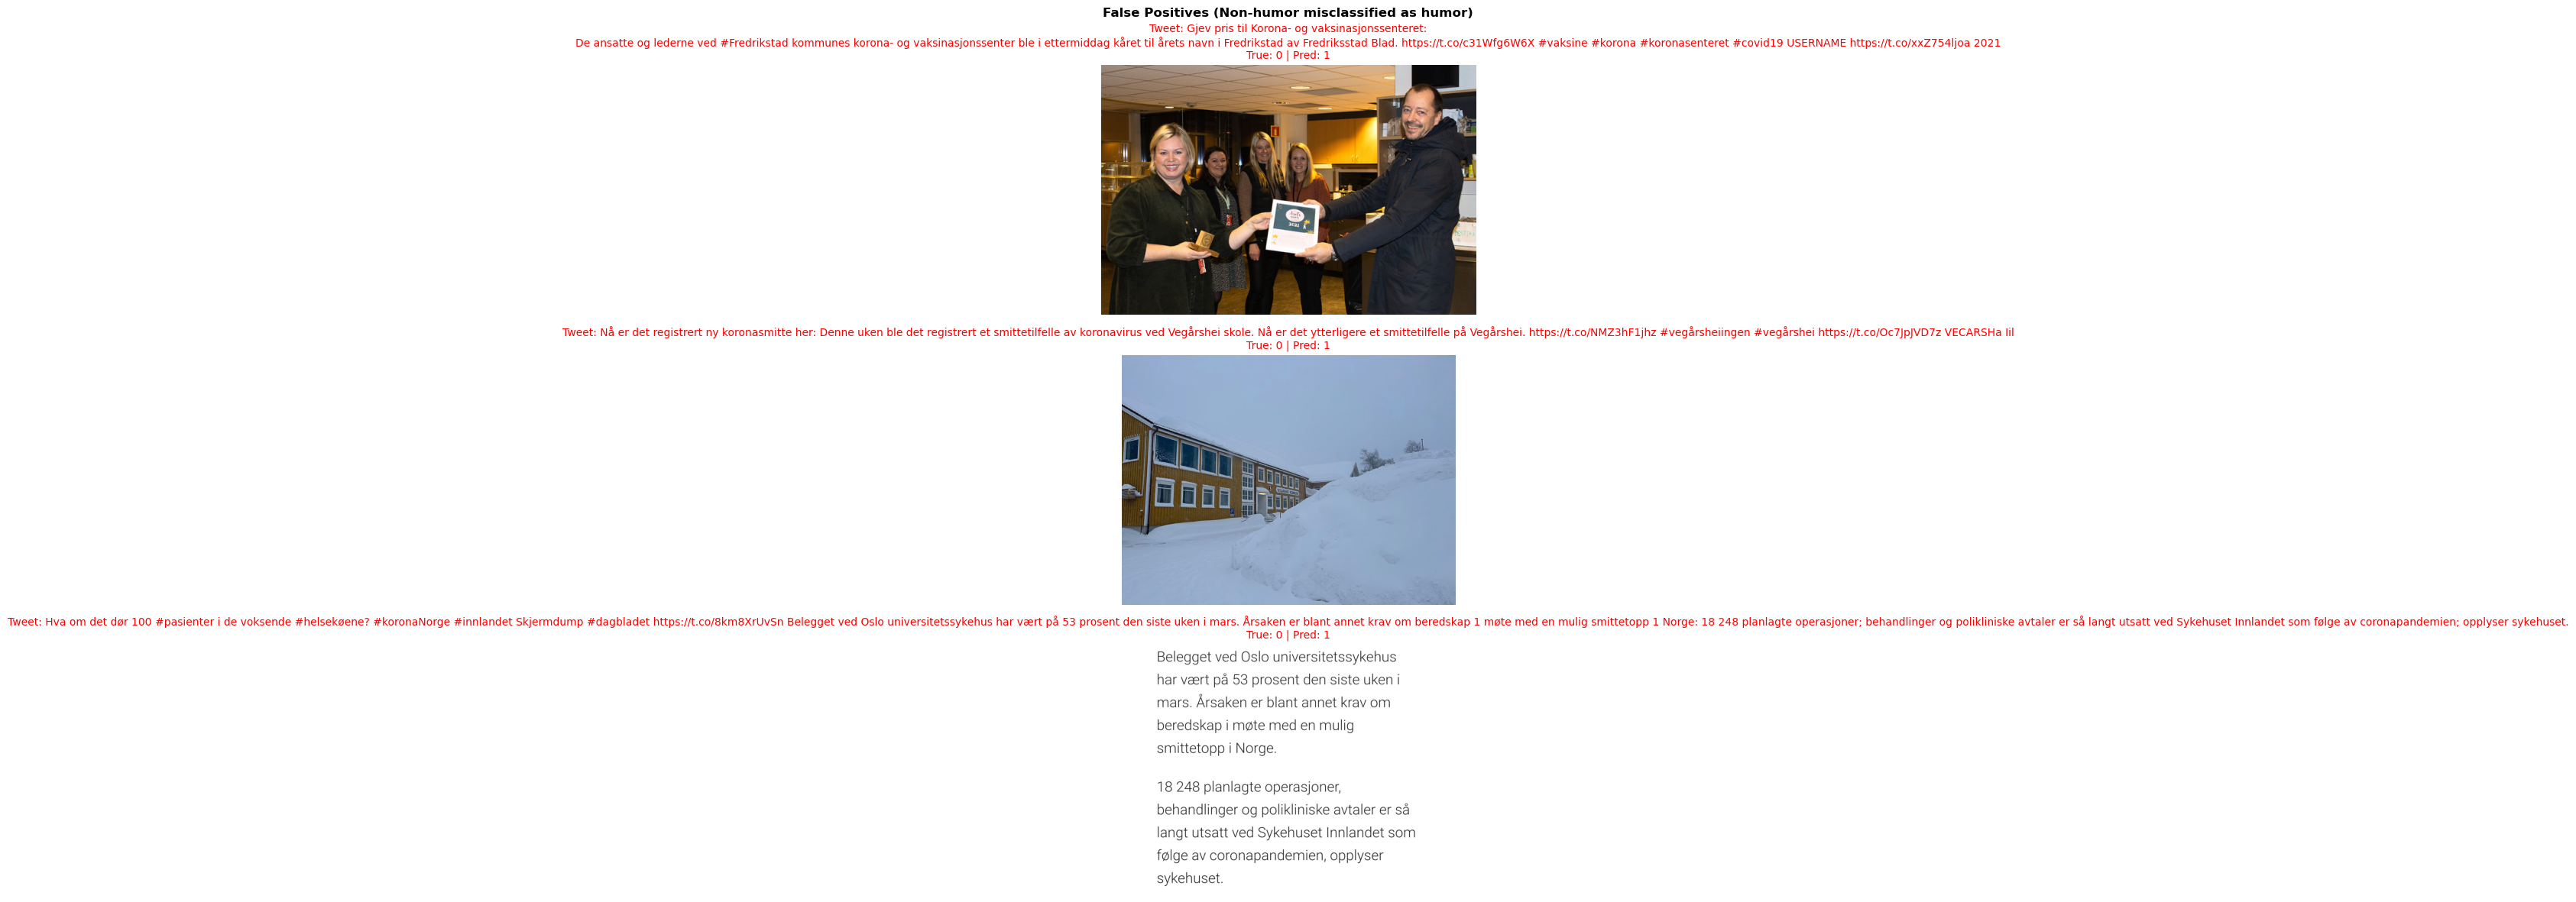

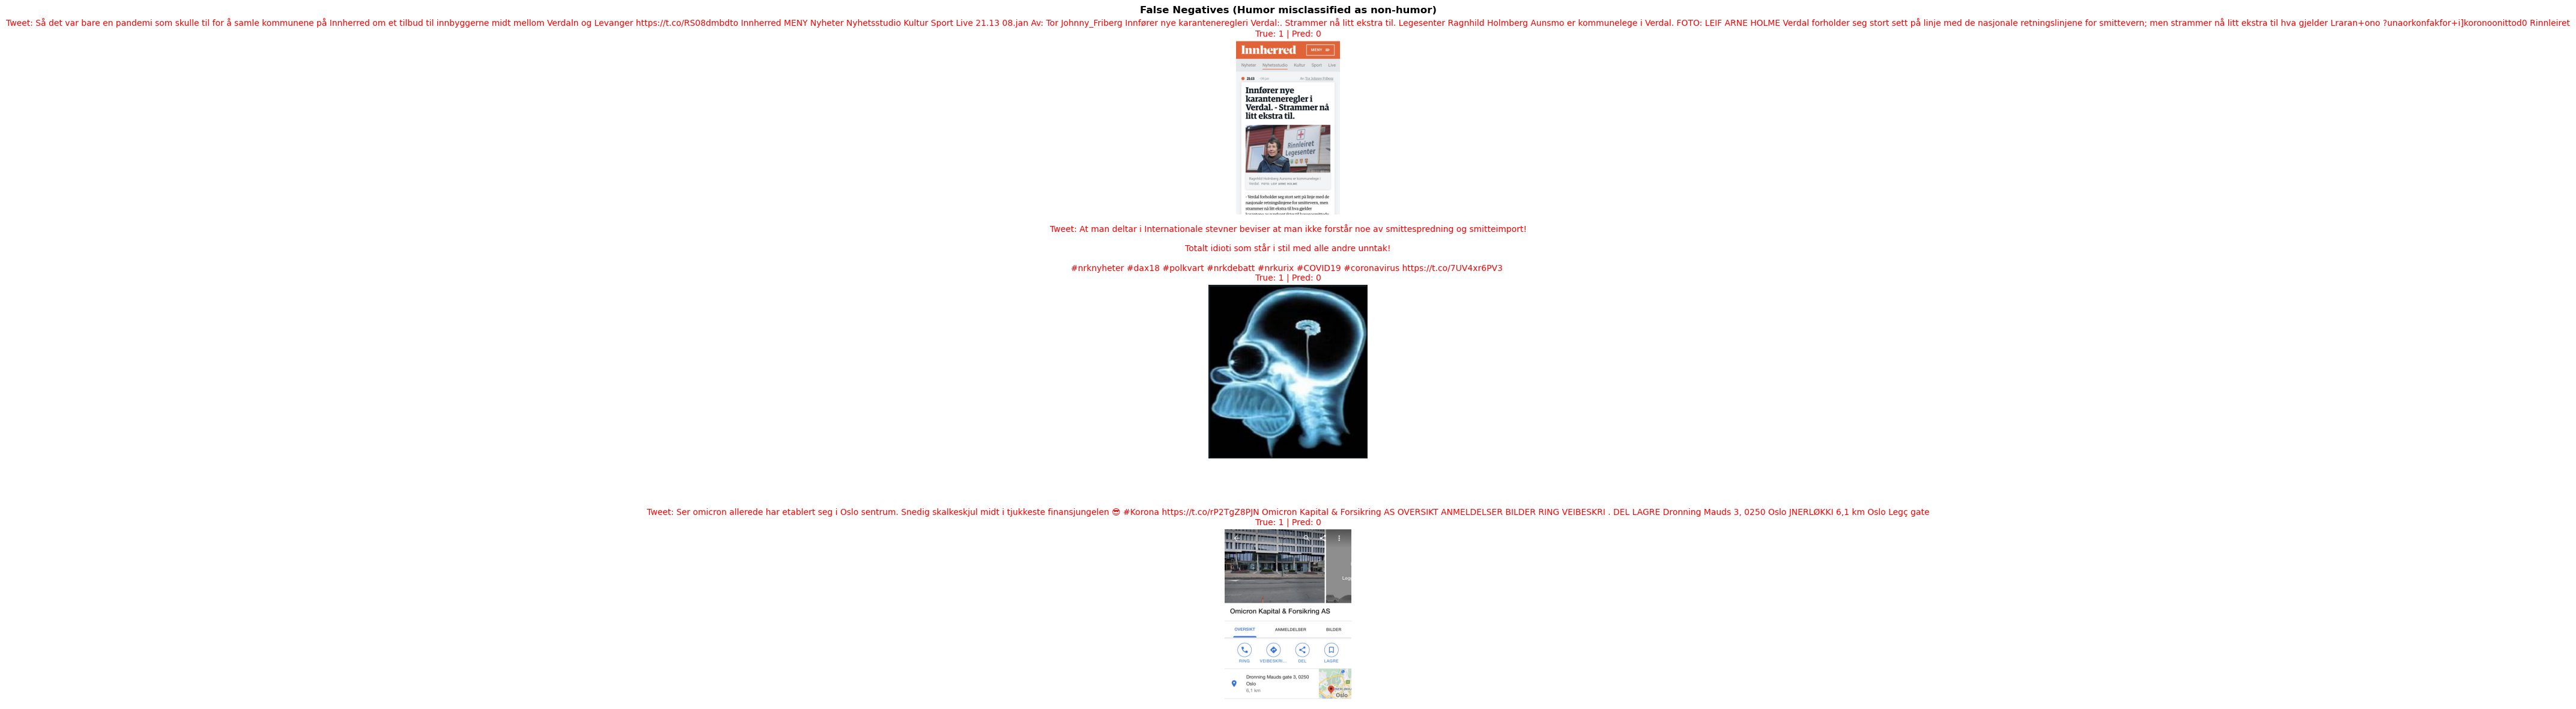

In [98]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_misclassified_samples(df_subset, title):
    """Displays misclassified examples with text and images."""
    fig, axes = plt.subplots(len(df_subset), 1, figsize=(8, len(df_subset) * 4))

    for i, (_, row) in enumerate(df_subset.iterrows()):
        # Load image if available
        img = mpimg.imread(row["image_path"]) if pd.notna(row["image_path"]) else None
        
        # Display image if present
        if img is not None:
            axes[i].imshow(img)
            axes[i].axis("off")

        # Display tweet text and labels
        text_info = f"Tweet: {row['tweet']}\nTrue: {row['true_label']} | Pred: {row['pred_label']}"
        axes[i].set_title(text_info, fontsize=10, color="red" if row['true_label'] != row['pred_label'] else "black")

    plt.suptitle(title, fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()

# Show misclassified examples
show_misclassified_samples(false_positives.head(3), "False Positives (Non-humor misclassified as humor)")
show_misclassified_samples(false_negatives.head(3), "False Negatives (Humor misclassified as non-humor)")